**Setup. Import required libraries and helper functions. Load our data.**

---



In [1]:
import os     # Used to sort files for file reading
from os import listdir
from os.path import isfile, join
import re     # Regex, used in the file reading

import cv2          # Open Computer Vision 2 - a must for any image manipulation
import imutils
import matplotlib.pyplot as plt

import numpy as np  # Other staples for working with images
import random
import copy
from skimage.util import random_noise

import torch
from torch import nn    # Pytorch
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, sampler

!pip install dsntnn     # Install library with DSNT layer
import dsntnn
from functools import reduce
from operator import mul

import scipy.misc       # Don't remember what this is used for - may not be needed

In [2]:
# Clone our labeled images stored in GitHub

!git clone https://github.com/Hunterdjensen/CS_6955_Project.git

Cloning into 'CS_6955_Project'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 6827 (delta 31), reused 431 (delta 15), pack-reused 6378
Receiving objects: 100% (6827/6827), 116.65 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Checking out files: 100% (6391/6391), done.


In [3]:
# Determine what type of device we are using

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

# Constant to control how frequently we print train loss
print_every = 100

using device: cuda:0


In [4]:
#
# Set Constants
# 

PATH_TO_IMAGE_FILES = '/content/CS_6955_Project/Examples'
CLASSIFICATION_RESULTS_FILENAME = 'classification_results.txt'

TEMPLATE_FILE_PATH = '/content/CS_6955_Project/Template/template_tight.png' # Used when generating synthetic data

In [5]:
#
# Helper functions for parsing the images
#

def line_to_points(line):
    """
    Converts an input line into a list of points
    """
    points_ascii = line.split("\t")[2]  # The 3rd column contains points data
    points = eval(points_ascii)         # Convert the string into a list
    points = np.array(points)           # List to numpy array of shape [num_cards, 4, 2]
    return points


def get_num_cards(line):
    return int(line.split("\t")[1])


def np_to_tuple(point):
    '''
    Most cv2 functions take coordinates in as a tuple, not an array with 2 elements
    so this function can be called to turn np array of shape [2] into a tuple
    '''
    return (point[0], point[1])


def displayRGB(image, points=None):
    """
    Displays an image and its coordinate points (if given) for pictures in 
    RGB format.
    """
    temp_img = image.copy()
    if points is not None:
        for j, frame in enumerate(points):
            for i, point in enumerate(frame):
                cv2.line(temp_img, np_to_tuple(point), np_to_tuple(points[j][i - 1]), (255, 0, 0), thickness=2)
    plt.imshow(temp_img)
    plt.axis('off')
    plt.show()


def expand_image(img, points, size=225):
    """
    Our network architechture is designed for square inputs.
    This function will perform the necessary scaling to get an input into the right format.
    """
    height, width, _ = img.shape
    points_oob = 0

    # Check how many points are out of bounds
    if points is not None:
      for card in points:
        for point in card:
          if (point[0] < 0) or (point[0] >= width) or (point[1] < 0) or (point[1] >= height):
            points_oob += 1
    
    # If picture is too big, scaled it down to the size
    if (height > width):
        if (height > size):
            img = imutils.resize(img, height=size)
    else:
        if (width > size):
            img = imutils.resize(img, width=size)

    # Regrab the new height and width
    height, width, _ = img.shape

    # If no points were passed in, assume the corners of the image
    if points is None:
        points = np.array([[[0, height], [0, 0], [width, 0], [width, height]]])

    # Add border (if the image isn't already square)
    left = int((size - width) / 2)  # So if image has width of 125, then left is 100/2=50
    right = int(size - (left+width))  # Remainder
    top = int((size - height) / 2)
    bottom = int(size - (top+height))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, (0, 0, 0))

    # Update points
    for i, card in enumerate(points):      # The first dim of 'points' is each card
        for j, point in enumerate(card):   # Second dimension is a list of 4 tuples (each corner point)
            points[i][j] = [point[0]+left, point[1]+top]    # Shift it to match the new image

    return (img, points, points_oob)


def read_images(max_samples=50000, 
                cards_per_image=1, 
                yellow_borders_only=True, 
                digital_images=False, 
                show_examples=False, 
                show_image=None, 
                max_corners_oob=0):
    """
    This function reads images in from the file system and creates a dataset.

    :param max_samples: Determines the number of sample images to load.
    :param cards_per_image: How many cards should be in each sample image? Defaults to 1
    :param yellow_borders_only: Determines whether the data set should be limited to trading cards with a yellow border
    :param digital_images:
    :param show_examples:
    :param show_image:
    :param max_corners_oob:
    """
    my_path = PATH_TO_IMAGE_FILES
    onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f))]
    onlyfiles = sorted(onlyfiles)
    os.chdir(my_path)   # cd into the directory 'my_path'

    label_filename = CLASSIFICATION_RESULTS_FILENAME
    label_file = open(label_filename, "a")
    label_file.close()

    x = np.array([], dtype=int)   # Numpy array holding each example image
    y = np.array([], dtype=int)   # Array holding the labels  (only supports exactly one card/img)

    i = 0
    for filename in onlyfiles:
        if not re.match(r".*.jpe", filename):
            continue  # We only want to look at image files, skip this one if not

        # Other criteria for the images:
        file_number = int(filename[0:6])  # First 6 chars of string are image number
        if yellow_borders_only:
            if (file_number >= 3000) and (file_number < 9000):   
                # Images 3000-3999 contain silver border, 4000-8999 black border, and 9000+ are digital
                # So for yellow borders only, exclude 3000-8999
                continue 
        if not digital_images:
            if (file_number >= 9000):
                # Similarly, if you don't want digital images, skip anything >9000
                continue    

        # Search the text file for the labels corresponding to this image
        found = False
        with open(label_filename) as file:
            for line in file:
                if filename in line:
                    num_cards = get_num_cards(line)
                    points = line_to_points(line)
                    found = True
                    break
        if found and (num_cards == cards_per_image):
            # Read in next photo
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            img, points, points_oob = expand_image(img, points)
            if (points_oob > max_corners_oob):
                continue  # If too many corners are out-of-bounds, skip this one
            x = np.concatenate((x, img[None,:,:,:]), axis=0) if x.size else img[None,:,:,:]
            y = np.concatenate((y, np.array(points)[None,:,:,:]), axis=0) if y.size else np.array(points)[None,:,:,:]
            if (show_examples and (i < 2)) or ((show_image is not None) and (show_image in filename)):
                print("Image " + str(i) + " shape: " + str(img.shape))
                print("Corner point coordinates: \n" + str(np.array(points)))
                displayRGB(img, points)
            if (y.shape[0] >= max_samples):
                break   # Exit once you have enough samples
            i += 1

    if x.size:
        x = np.moveaxis(x, -1, 1)   # Move the depth to the second position
    y = np.squeeze(y, axis=1) # Temporarily remove the 1th dimension (which contains how many cards/image) so it matches coords from DSNT
    print("X shape: " + str(x.shape))    # Dimensions are: [example, depth, height, width]
    print("Y shape: " + str(y.shape))    # Dimensions are: [example, cards in image, corners, coordinate]

    return x, y


def shuffle_two_arrays(x, y):
    rand_idxs = np.random.permutation(y.shape[0])
    return x[rand_idxs], y[rand_idxs]
  

def split_dataset(x, y):
    """
    Split into training, validation, and test datasets

    :returns: tuple of (x_train, y_train, x_val, y_val, x_test, y_test)
    """
    x, y = shuffle_two_arrays(x, y)
    num_examples = x.shape[0]
    p8 = round(num_examples * 0.8)
    p9 = round(num_examples * 0.9)
    x_train = x[:p8, :, :, :]
    try:
      y_train = y[:p8, :, :, :]
    except:   # If y only has 3 dimensions (when only 1 point, not 4)
      y_train = y[:p8, :, :]
    x_val = x[p8:p9, :, :, :]
    try:
      y_val = y[p8:p9, :, :, :]
    except:
      y_val = y[p8:p9, :, :]
    x_test = x[p9:, :, :, :]
    try:
      y_test = y[p9:, :, :, :]
    except:
      y_test = y[p9:, :, :]
    return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
# Test usage of read_images:
# x, y = read_images(max_samples=3, show_examples=True, yellow_borders_only=True, digital_images=False, cards_per_image=1)

X shape: (3, 3, 225, 225)
Y shape: (3, 4, 2)


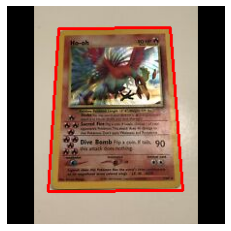

[[ 42 191]
 [ 53  23]
 [168  22]
 [181 190]]


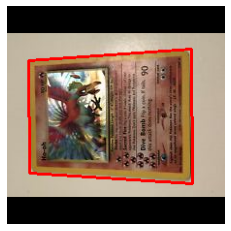

[[ 23 172]
 [ 22  56]
 [190  44]
 [191 183]]


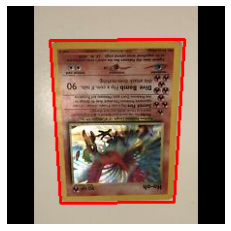

[[ 55 203]
 [ 44  35]
 [183  34]
 [172 202]]


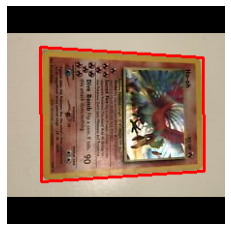

[[ 35 181]
 [ 34  42]
 [202  53]
 [203 170]]


In [7]:
def rot_coords(y, angle, size=225):
  '''
  Takes in a matrix y of shape [N, 4, 2] (four (x,y) coordinates per N)
  and rotates them by 'angle' degrees, counterclockwise.  The parameter
  'size' is used to find the center of rotation, aka the middle of the image.
  '''
  y_r = copy.deepcopy(y).astype(float)  # Copy input matrix

  s = np.sin(np.deg2rad(angle))
  c = np.cos(np.deg2rad(angle))
  rot_matrix = np.array([[c, -s],[s, c]])   # Rotational matrix

  center = 225/2    # Center of rotation (middle of picture)

  y_r = y_r - center  # Move image to the origin
  y_r = np.dot(y_r, rot_matrix) # Rotate coordinates
  y_r = y_r + center  # Move image back to original location

  return y_r.astype(int)


def rotate_dataset_by_90s(x, y):
  '''
  Takes in a dataset with x of shape [N, 3, height, width] and y of shape
  [N, 4, 2] and returns (x, y) with 4*N examples.  It rotates each of the 
  dataset images by 90, 180, and 270 degrees, along with their coordinates,
  and return the new, larger dataset.
  '''
  x_90 = np.rot90(x, axes=(-2, -1))
  x_180 = np.rot90(x_90, axes=(-2, -1))
  x_270 = np.rot90(x_180, axes=(-2, -1))

  y_90 = rot_coords(y, 90)
  y_90 = np.roll(y_90, -1, axis=1)  # Roll is used to reorder the coordinates.  Order should always be: bottom left, top left, top right, bottom right

  y_180 = rot_coords(y_90, 90)
  y_180 = np.roll(y_180, -1, axis=1)

  y_270 = rot_coords(y_180, 90)
  y_270 = np.roll(y_270, -1, axis=1)

  final_x = np.vstack((x, x_90, x_180, x_270))
  final_y = np.vstack((y, y_90, y_180, y_270))
  
  return final_x, final_y


# Shown below is an example usage, which will print out an image specified by img_num
# 4 times, for each rotation
x, y = read_images(max_samples=3, cards_per_image=1)
x_new, y_new = rotate_dataset_by_90s(x,y)
img_num = 2   # Which image you want to check rotated
for img in np.linspace(0, x_new.shape[0], num=4, endpoint=False, dtype=int): # range(x_new.shape[0]):
  img = img + img_num
  displayRGB(x_new[img].transpose((1,2,0)), y_new[None, img, :, :])
  print(y_new[img])

In [8]:
def rand_gauss(m, s, w=56):   # w (max width) defaults to 56, or 225/4
  m = int(m)
  num = np.random.normal(m, s)
  if num < m-w:
    num = m-w
  if num > m+w:
    num = m+w;
  if round(num) < 0:
    print("ERROR: Rand_gauss returned a value < 0, m=" + str(m) + " s=" + str(s) + " w=" + str(w))
  if round(num) > 224:
    print("ERROR: Rand_gauss returned a value of > 244: " + str(num))
  return round(num)


# Creates black and white example images with perspective warp/noise
# Use the mode 'test' to create simple images that are all square, otherwise they'll
# be distorted rectangles.
def create_examples(num_examples, size=225, show_examples=False, mode=None):
  """
  This function creates a synthetic data set, which was useful in early development.
  """
  filename = TEMPLATE_FILE_PATH
  orig = cv2.imread(filename)
  orig, points, _ = expand_image(orig, None, size=size)
  if show_examples is True:
    # orig = random_noise(orig, mode='s&p',amount=0.3)  # Converts each pixel to float from [0,1]
    noisy_orig = random_noise(orig, mode='gaussian', clip=True, var=0.02)
    noisy_orig = np.array(255*noisy_orig, dtype = 'uint8')        # Convert back to int in range [0,255]
    plt.imshow(noisy_orig)
    plt.show()
    print("points on original image: " + str(points))
    print("size: " + str(size))

  if mode is 'test':
    s = 0.0001
  else:
    s = round(size/11)   # Standard deviation of examples - 20 if size=225
  w = round(size/4) # 56 if size=225
  # The contour making a diamond through the image, we don't want points inside this diamond
  cnt = np.array([[0, int(size/2)], [int(size/2), 0], [size, int(size/2)], [int(size/2), size]])

  x = np.array([], dtype=int)   # Numpy array holding each example image
  y = np.array([], dtype=int)   # Array holding the labels  (only supports exactly one card/img)

  for ex in range(num_examples):
    new_points = copy.deepcopy(points)
    for i, card in enumerate(new_points):
      new_points[i][0] = (rand_gauss(size/4, s, w=w), rand_gauss(3*size/4, s, w=w))  # Bottom left
      while (cv2.pointPolygonTest(cnt, np_to_tuple(new_points[i][0]), False) > 0): # Positive if point is inside shape defined as cnt
        new_points[i][0] = (rand_gauss(size/4, s, w=w), rand_gauss(3*size/4, s, w=w)) 

      new_points[i][1] = (rand_gauss(size/4, s, w=w), rand_gauss(size/4, s, w=w))  # Top left
      while (cv2.pointPolygonTest(cnt, np_to_tuple(new_points[i][1]), False) > 0):
        new_points[i][1] = (rand_gauss(size/4, s, w=w), rand_gauss(size/4, s, w=w))

      new_points[i][2] = (rand_gauss(3*size/4, s, w=w), rand_gauss(size/4, s, w=w))  # Top right
      while (cv2.pointPolygonTest(cnt, np_to_tuple(new_points[i][2]), False) > 0):
        new_points[i][2] = (rand_gauss(3*size/4, s, w=w), rand_gauss(size/4, s, w=w))

      new_points[i][3] = (rand_gauss(3*size/4, s, w=w), rand_gauss(3*size/4, s, w=w))  # Bottom right
      while (cv2.pointPolygonTest(cnt, np_to_tuple(new_points[i][3]), False) > 0):
        new_points[i][3] = (rand_gauss(3*size/4, s, w=w), rand_gauss(3*size/4, s, w=w))

    pts1 = np.array(points, np.float32).squeeze()
    pts2 = np.array(new_points, np.float32).squeeze()
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(orig, M, (size, size))
    img = random_noise(img, mode='gaussian', clip=True, var=0.02)
    img = np.array(255*img, dtype = 'uint8')
    x = np.concatenate((x, img[None,:,:,:]), axis=0) if x.size else img[None,:,:,:]
    y = np.concatenate((y, np.array(new_points)[None,:,:,:]), axis=0) if y.size else np.array(new_points)[None,:,:,:]
    if show_examples and ex < 5:
      plt.subplot(1,5,ex+1), plt.imshow(img)

  if show_examples:
    plt.show()
  if x.size:
    x = np.moveaxis(x, -1, 1)   # Move the depth to the second position
  y = np.squeeze(y, axis=1)
  print("X shape: " + str(x.shape))    # Dimensions are: [example, depth, height, width]
  print("Y shape: " + str(y.shape))    # Dimensions are: [example, cards in image, corners, coordinate]
  # cv2.drawContours(orig, [cnt], 0, (255, 0, 0), 3)  # Draws contour over "orig" if you want to check it

  return x, y

In [9]:
def img_to_tensor(image):
  """
  Convert an image to a tensor
  """
  try:
    img_tensor = torch.from_numpy(image).permute(2, 0, 1).float()   # Move the depth to the start
    input_tensor = img_tensor.div(255).unsqueeze(0)   # If just one image, add another dimension at front
  except:
    img_tensor = torch.from_numpy(image).permute(0, 3, 1, 2).float()
    input_tensor = img_tensor.div(255)
  return input_tensor.to(device)

In [10]:
def coords_to_points(coords, image_size=(225, 225)):
  output = (((coords.cpu() + 1) * torch.Tensor(image_size)) - 1) / 2
  output = torch.round(output)
  return output


def points_to_coords(points, image_size=(225, 225)):
  return ((points * 2 + 1) / torch.Tensor(image_size)) - 1

In [11]:
### Override this method from dsntnn because it doesn't work on cuda ###
# The error message is: 
#   RuntimeError: view size is not compatible with input tensor's size and 
#   stride (at least one dimension spans across two contiguous subspaces). Use 
#   .reshape(...) instead.
# 
# On our example with 2 images with 2 points each: 
#   orig_size: torch.Size([2, 2, 40, 40])
#   inp shape: torch.Size([2, 2, 40, 40])
#   flat shape: torch.Size([4, 1600])

def _flat_softmax(inp):
    """
    Compute the softmax with all but the first two tensor dimensions combined.
    """

    orig_size = inp.size()
    # print("orig_size: " + str(orig_size))
    # print("inp shape: " + str(inp.shape))
    # flat = inp.view(-1, reduce(mul, orig_size[2:])) # This was the original line, causing errors
    flat = torch.reshape(inp, (orig_size[0]*orig_size[1], orig_size[2]*orig_size[3]))
    # print("flat shape: " + str(flat.shape))
    flat = torch.nn.functional.softmax(flat, -1)
    return flat.view(*orig_size)

dsntnn.flat_softmax = _flat_softmax

In [12]:
def numpy_normalize_rgb(x, show_examples=False):
  '''
    Takes an input x of size (N, 3, H, W) and returns x_norm of same shape
    Each RGB value will have the dataset mean subtracted from it, and divided
    by the std.
  '''
  x_t = x.transpose((0, 2, 3, 1))
  x_norm = (x_t - x_t.mean(axis=(0, 1, 2), keepdims=True)) / x_t.std(axis=(0, 1 ,2), keepdims=True)
  x_norm = np.clip(x_norm, 0, 1)    # Images are now in the [-1,2.5] range, clip to [0,1]
  x_norm = (x_norm * 255).astype('uint8')   # And convert back to [0,255] ints
  if show_examples:
    plt.subplot(1,2,1), plt.imshow(x_t[0])
    plt.subplot(1,2,2), plt.imshow(x_norm[0])
    plt.show()
  x_norm = x_norm.transpose((0, 3, 1, 2))
  return x_norm

# x, y = read_images()
# x, y = create_examples(10, size=225)
# numpy_normalize_rgb(x, show_examples=True);

In [13]:
def check_accuracy(loader, model, max_dist=2): 
  """
  Compute the accuracy of our classifications. 
  We do this by determining how many points were within a certain distance from where they should have been.
  We will run this function several times and report the results at various thresholds.
  :param loader:
  :param model: Our trained model
  :param max_dist: Our threshold distance from the target points that we will accept
  :returns: Accurracy metric
  """
  num_correct = 0
  num_samples = 0
  # model.eval()  # FIXME: Eval mode is broken? Gives horrible results
  model.train()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)  # move to device, e.g. GPU
      y = y.to(device=device)
      coords, heatmaps, _ = model(x)
      diff = coords_to_points(coords) - coords_to_points(y)
      diff = np.array(torch.abs(diff))
      # Commented out is a for-loop implementation
      # for sample in diff:
      #   num_samples += 1
      #   correct = 1
      #   for point in sample:
      #     if (point[0] > max_dist) or (point[1] > max_dist):
      #       correct = 0
      #   num_correct += correct

      # Below is the numpy vectorized version.  You're just checking diff <= max_dist 
      # for each example, really. This means each of the 4 corners is predicted 
      # within max_dist pixels.  (i.e. a prediction of (1,1) when it should be 
      # (0,0) is still marked as correct if max_dist=1)
      diff = np.all(np.all(diff<=max_dist, axis=2),axis=1)
      num_correct += np.sum(diff)
      num_samples += diff.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc


def show_worst(loader, model, max_dist=2, show_up_to=5): 
  """
  Display the images which the largest error in classification
  """
  num_correct = 0
  num_incorrect = 0
  num_samples = 0
  num_shown = 0;
  # model.eval()  # FIXME: Eval mode is broken? Gives horrible results
  model.train()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)  # move to device, e.g. GPU
      y = y.to(device=device)
      coords, heatmaps, _ = model(x)
      diff = coords_to_points(coords) - coords_to_points(y)
      diff = np.array(torch.abs(diff))
      # Commented out is a for-loop implementation
      for i, sample in enumerate(diff):
        num_samples += 1
        correct = 1
        incorrect = 0
        shown = False
        for point in sample:
          if (point[0] > max_dist) or (point[1] > max_dist):
            correct = 0
            incorrect = 1
            if (num_shown < show_up_to) and shown is False:
              num_shown += 1
              shown = True
              # img = x[i, :, :, :].detach().cpu().numpy()
              # img = np.transpose(img, (1, 2, 0))
              # plt.figure(figsize=(50,100))
              # plt.subplot(1,show_up_to,num_shown, ), plt.imshow(img)
        if shown is True:
          img = x[i, :, :, :].detach().cpu().numpy()
          img = np.transpose(img, (1, 2, 0))
          sample = coords_to_points(coords[i])
          points = []
          points.append([])
          points[0].append((sample[0][0], sample[0][1]))
          points[0].append((sample[1, 0], sample[1, 1]))
          points[0].append((sample[2][0], sample[2][1]))
          points[0].append((sample[3][0], sample[3][1]))
          # print(sample[None, :, :].tolist())
          displayRGB(img, points)
        num_correct += correct
        num_incorrect += incorrect

      # Below is the numpy vectorized version.  You're just checking diff <= max_dist 
      # for each example, really. This means each of the 4 corners is predicted 
      # within max_dist pixels.  (i.e. a prediction of (1,1) when it should be 
      # (0,0) is still marked as correct if max_dist=1)
      # diff = np.all(np.all(diff<=max_dist, axis=2),axis=1)
      # num_correct += np.sum(diff)
      # num_samples += diff.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    plt.show()
  # return acc

In [14]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Code borrowed from a homework.
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Code borrowed from a homework.
  Train a model using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  # loss_history = torch.zeros(num_prints, dtype=torch.float)
  loss_history = []
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device)  # move to device, e.g. GPU
      y = y.to(device=device)

      # Run it through the model
      coords, heatmaps, _ = model(x)

      # Calculate the loss
      euc_losses = dsntnn.euclidean_losses(coords, y)
      reg_losses = dsntnn.js_reg_losses(heatmaps, y, sigma_t=1.0)
      loss = dsntnn.average_loss(euc_losses + reg_losses)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        # loss_history[t // print_every] = loss
        loss_history.append(loss.item())
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        # loss_history[e] = loss
        loss_history.append(loss.item())
  return loss_history, acc_history, iter_history

**Define the core components we need for our model architecture**


---



In [15]:
class FCN(nn.Module):
    """
    Defines a network with the following architechture:
    - 2D Convolutional Layer
    - ReLU Activation
    - 2D Batch Normalization
    - 2D Convolutional Layer
    - ReLU Activation
    - 2D Batch Normalization
    - 2D Convolutional Layer
    """
    def __init__(self, H):
        super().__init__()
        self.H = H

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.H, kernel_size=11, padding=7),
            nn.ReLU(),
            nn.BatchNorm2d(H),
            nn.Conv2d(self.H, self.H, kernel_size=13, padding=6),
            nn.ReLU(),
            nn.BatchNorm2d(self.H),
            nn.Conv2d(self.H, self.H, kernel_size=15, padding=5, bias=True),
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
class CRN(nn.Module):
    def __init__(self, n_locations, H=16):
        super().__init__()
        self.H = H
        self.fcn = FCN(H)
        self.hm_conv = nn.Conv2d(H, n_locations, kernel_size=1, bias=False)

    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)    # Shape [N, H, 255, 255]
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # print("u heatmaps: " + str(unnormalized_heatmaps.shape))
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # print("heatmaps: " + str(heatmaps.shape))
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)

        return coords, heatmaps, unnormalized_heatmaps

In [17]:
class PlainBlock(nn.Module):
  """
  Code borrowed from our ResNet homework.
  """
  def __init__(self, Cin, Cout, downsample=False, kernel=3):
    super().__init__()

    self.net = None
    ############################################################################
    # TODO: Implement plain block.                                             #
    # Hint: Wrap your layers by nn.Sequential() to output a single module.     #
    #       You don't have use OrderedDict.                                    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the result in self.net.                                            #
    ############################################################################
    # Replace "pass" statement with your code
    strd = 1
    if downsample:
      strd = 2

    num_hidden_channels = int((Cin + Cout) / 2)

    self.net = nn.Sequential(
        nn.BatchNorm2d(Cin), # The doc says num_features is C from expected input of size (N, C, H, W)
        nn.ReLU(),
        nn.Conv2d(Cin, num_hidden_channels, kernel, padding=int((kernel-1)/2), stride=strd),
        nn.BatchNorm2d(num_hidden_channels),
        nn.ReLU(),
        nn.Conv2d(num_hidden_channels, Cout, kernel, padding=int((kernel-1)/2))
    )
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################

  def forward(self, x):
    return self.net(x)

In [18]:
class ResidualBlock(nn.Module):
  """
  Code borrowed from our ResNet homework.
  """
  def __init__(self, Cin, Cout, downsample=False, kernel=3):
    super().__init__()

    self.block = None # F
    self.shortcut = None # G
    ############################################################################
    # TODO: Implement residual block using plain block. Hint: nn.Identity()    #
    # Inputs:                                                                  #
    # - Cin: number of input channels                                          #
    # - Cout: number of output channels                                        #
    # - downsample: add downsampling (a conv with stride=2) if True            #
    # Store the main block in self.block and the shortcut in self.shortcut.    #
    ############################################################################
    strd = 1
    if downsample:
      strd = 2

    self.block = PlainBlock(Cin, Cout, downsample=downsample, kernel=kernel)
    self.shortcut = nn.Sequential(
        nn.Conv2d(Cin, Cout, 1, stride=strd)
    )
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
  
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [19]:
class ResNetStage(nn.Module):
  """
  Code borrowed from our ResNet homework.
  """
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock, kernel=3):
    super().__init__()
    blocks = [block(Cin, Cout, downsample, kernel=kernel)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout, kernel=kernel))
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)

In [20]:
class ResNetStem(nn.Module):
  """
  Code borrowed from our ResNet homework.
  """
  def __init__(self, Cin=3, Cout=8, kernel=3):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=kernel, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)

In [21]:
class ResNet(nn.Module):
  """
  Code borrowed from our ResNet homework.
  """
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, kernel=None, n_locations=4):
    super().__init__()

    self.cnn = None
    # stage_args is Cin, Cout, Num Blocks, Downsample
    if kernel is None:
      kernel = [3, 3, 3, 3, 3, 3]
    stages = [ResNetStem(Cin, stage_args[0][0], kernel=kernel[0])]  # Interface with first actual stage - get right amount of channels
    for i, stage in enumerate(stage_args):
      stages.append(ResNetStage(stage[0], stage[1], stage[2], kernel=kernel[i], downsample=stage[3], block=block))

    self.cnn = nn.Sequential(*stages)
    ############################################################################
    #                                 END OF YOUR CODE                         #
    ############################################################################
    self.hm_conv = nn.Conv2d(stage_args[-1][1], n_locations, kernel_size=1, bias=False)
  
  def forward(self, images):
      # 1. Run the images through our FCN
      fcn_out = self.cnn(images)    # Shape [N, H, 255, 255]

      # 2. Use a 1x1 conv to get one unnormalized heatmap per location
      unnormalized_heatmaps = self.hm_conv(fcn_out) # [N, n_locations, 255, 255]

      # 3. Normalize the heatmaps
      heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)

      # 4. Calculate the coordinates
      coords = dsntnn.dsnt(heatmaps)

      return coords, heatmaps, unnormalized_heatmaps

In [22]:
# Dictionary of networks that are premade to pull from: 
networks = {
  'plain4': {
    'block': PlainBlock,
    'stage_args': [
      (8, 16, 1, False),               
    ]    
  },
  'plain4k': {
    'block': PlainBlock,
    'stage_args': [
      (8, 16, 1, False),               
    ],
    'kernel': [15, 17]
  },
  'plain6': {             # Final loss: 0.00823.  Achieve 40/40 at 5 pixels away,
    'block': PlainBlock,  # 37/40 (92.5%) at 4, with lr = 2.5e-3       
    'stage_args': [
      (8, 16, 1, False),
      (16, 32, 1, False)             
    ]
  },
  'plain6k': {         
    'block': PlainBlock,      
    'stage_args': [
      (8, 16, 1, False),
      (16, 32, 1, False)             
    ],
    'kernel': [9, 13, 19]
  },
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, False),
      (16, 32, 5, False),
    ]
  },
  'resnet4': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 16, 1, False)             
    ]
  },
  'resnet4k': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 16, 1, False)             
    ],
    'kernel': [15, 17]
  },
  'resnet4kD': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 16, 1, True)             
    ],
    'kernel': [15, 17]
  },
  'resnet6k': { 
    'block': ResidualBlock,      
    'stage_args': [
      (8, 16, 1, False),
      (16, 32, 1, False)             
    ],
    'kernel': [15, 17, 19]
  },
  'resnet6kD': { 
    'block': ResidualBlock,      
    'stage_args': [
      (8, 16, 1, True),
      (16, 32, 1, False)             
    ],
    'kernel': [15, 17, 19]
  },
  'resnet8': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 16, 2, False),
      (16, 32, 1, False)               
    ]
  },
  'resnet8k': { 
    'block': ResidualBlock,      
    'stage_args': [
      (8, 16, 2, False),
      (16, 32, 1, False)             
    ],
    'kernel': [15, 17, 19]
  },
  'resnet12': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 16, 3, False),
      (16, 32, 2, False)               
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, False),
      (16, 32, 5, False),
    ]
  },
}

def get_net(name):
  if name is 'crn':
    return CRN(n_locations=4, H=16)
  else:
    return ResNet(**networks[name])

In [23]:
# print(get_net('resnet8'))

**Set up for Training**

---



In [24]:
# x, y = create_examples(400, show_examples=False, size=225) # if mode=='test', it will generate only simple squares
x, y = read_images(max_samples=4000, show_examples=False, yellow_borders_only=True)
x, y = rotate_dataset_by_90s(x,y)
print("X shape after transformations: " + str(x.shape))

# x = numpy_normalize_rgb(x)

# Split the data set
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(x, y)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
NUM_TRAIN = x_train.shape[0]
NUM_VAL = x_val.shape[0]
NUM_TEST = x_val.shape[0]

x_train_var = torch.from_numpy(x_train).div(255)
y_train_var = torch.from_numpy(y_train)
y_train_var = points_to_coords(y_train_var, image_size=(225, 225))
x_val_var = torch.from_numpy(x_val).div(255)
y_val_var = torch.from_numpy(y_val)
y_val_var = points_to_coords(y_val_var, image_size=(225, 225))
x_test_var = torch.from_numpy(x_test).div(255)
y_test_var = torch.from_numpy(y_test)
y_test_var = points_to_coords(y_test_var, image_size=(225, 225))

# Get rid of the numpy arrays now that there are copies as tensors
del x_train
del y_train
del x_val
del y_val
del x_test
del y_test

train_dataset = TensorDataset(x_train_var, y_train_var)
loader_train = DataLoader(train_dataset, batch_size=16, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
print(str(len(loader_train)) + " minibatches in the training dataset")

val_dataset = TensorDataset(x_val_var, y_val_var)
loader_val = DataLoader(val_dataset, batch_size=16, sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test_dataset = TensorDataset(x_test_var, y_test_var)
loader_test = DataLoader(test_dataset, batch_size=16, sampler=sampler.SubsetRandomSampler(range(NUM_TEST)))

X shape: (2025, 3, 225, 225)
Y shape: (2025, 4, 2)
X shape after transformations: (8100, 3, 225, 225)
(6480, 3, 225, 225)
(810, 3, 225, 225)
(810, 3, 225, 225)
405 minibatches in the training dataset


**Perform Training**

---



Epoch 0, Iteration 404, loss = 0.0916
Got 621 / 810 correct (76.67)
Epoch 1, Iteration 809, loss = 0.0686
Got 672 / 810 correct (82.96)
Epoch 2, Iteration 1214, loss = 0.0583
Got 677 / 810 correct (83.58)
Epoch 3, Iteration 1619, loss = 0.0646
Got 668 / 810 correct (82.47)
Epoch 4, Iteration 2024, loss = 0.0592
Got 701 / 810 correct (86.54)
Epoch 5, Iteration 2429, loss = 0.0599
Got 706 / 810 correct (87.16)
Epoch 6, Iteration 2834, loss = 0.0396
Got 705 / 810 correct (87.04)
Epoch 7, Iteration 3239, loss = 0.0530
Got 704 / 810 correct (86.91)
Epoch 8, Iteration 3644, loss = 0.0449
Got 727 / 810 correct (89.75)
Epoch 9, Iteration 4049, loss = 0.0523
Got 730 / 810 correct (90.12)
Epoch 10, Iteration 4454, loss = 0.0759
Got 708 / 810 correct (87.41)
Epoch 11, Iteration 4859, loss = 0.1100
Got 735 / 810 correct (90.74)
Epoch 12, Iteration 5264, loss = 0.0412
Got 733 / 810 correct (90.49)
Epoch 13, Iteration 5669, loss = 0.0546
Got 725 / 810 correct (89.51)
Epoch 14, Iteration 6074, loss =

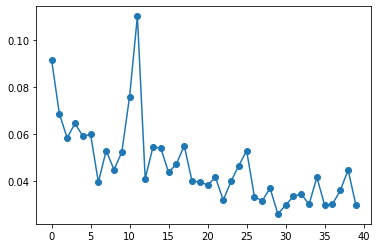

final loss: 0.029951293021440506


In [25]:
#
# Train our model
#

# model = get_net('crn')
model = get_net('resnet6kD')

# optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)
optimizer = optim.Adam(model.parameters(), lr=2.5e-3)

loss_history, acc_history, iter_history = train(model, optimizer, epochs=40, learning_rate_decay=0.5, schedule=[25, 30, 35], verbose=False)

plt.plot(loss_history, '-o')
plt.show()
print("final loss: " + str(loss_history[-1]))

In [26]:
#
# Check the accuracy
#

acc = check_accuracy(loader_val, model, max_dist=5)
acc = check_accuracy(loader_val, model, max_dist=4)
acc = check_accuracy(loader_val, model, max_dist=3)
acc = check_accuracy(loader_val, model, max_dist=2)
acc = check_accuracy(loader_val, model, max_dist=1)
acc = check_accuracy(loader_val, model, max_dist=0)

Got 787 / 810 correct (97.16)
Got 782 / 810 correct (96.54)
Got 773 / 810 correct (95.43)
Got 743 / 810 correct (91.73)
Got 504 / 810 correct (62.22)
Got 10 / 810 correct (1.23)


**Show the Network Architecture**

---





In [27]:
print(model)

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 8, kernel_size=(15, 15), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBlock(
          (block): PlainBlock(
            (net): Sequential(
              (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU()
              (2): Conv2d(8, 12, kernel_size=(15, 15), stride=(2, 2), padding=(7, 7))
              (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (4): ReLU()
              (5): Conv2d(12, 16, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
            )
          )
          (shortcut): Sequential(
            (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2))
          )
        )
      )
    )
    (2): ResNetStage(
      (net): Sequential(
        (0): ResidualBlock(
          (block

**Visualize the Results**

---

We will show heat maps from the network and then display the images which had the greatest classification errors so we can learn what type of problems our network is having.

tensor([ 69., 145.], grad_fn=<RoundBackward>)
tensor([69., 76.], grad_fn=<RoundBackward>)
tensor([166.,  77.], grad_fn=<RoundBackward>)
tensor([164., 146.], grad_fn=<RoundBackward>)
tensor([[ 68., 145.],
        [ 69.,  76.],
        [165.,  77.],
        [164., 147.]])


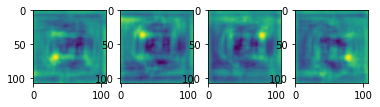

In [28]:
#
# Visualize heatmaps from the network
#
coords, _, heatmaps = model(x_train_var[0:1].to(device))

print(coords_to_points(coords[0,0]))
print(coords_to_points(coords[0,1]))
print(coords_to_points(coords[0,2]))
print(coords_to_points(coords[0,3]))
print(coords_to_points(y_train_var[0]))

plt.subplot(1,4,1), plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
plt.subplot(1,4,2), plt.imshow(heatmaps[0, 1].detach().cpu().numpy())
plt.subplot(1,4,3), plt.imshow(heatmaps[0, 2].detach().cpu().numpy())
plt.subplot(1,4,4), plt.imshow(heatmaps[0, 3].detach().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


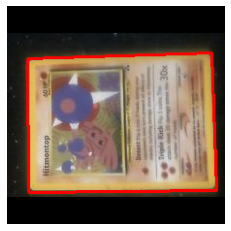

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


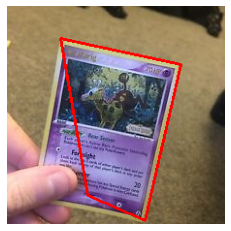

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


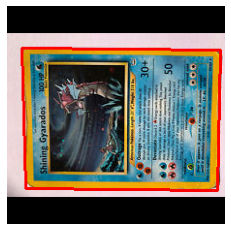

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


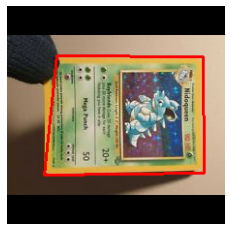

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


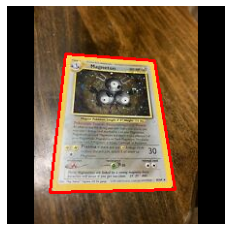

Got 787 / 810 correct (97.16)


In [29]:
#
# Show the images which had the highest error
#
show_worst(loader_val, model, max_dist=5)